#Support Vector Machines with 3 Kernels:
<b>
-Linear Kernel <br>
-Polynomial Kernel<br>
-Gaussian Kernel<br>
</b>

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as mpl
from sklearn.cross_validation import KFold 
from sklearn import datasets, linear_model
from sklearn.preprocessing import PolynomialFeatures,normalize
from collections import defaultdict
import csv
import cvxopt as cvx
from cvxopt import solvers
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def replace_zero(x):
    '''
    To avoid divide by zero errors.
    '''
    if x == 0 :
        return 1
    else:
        return x

In [5]:
def print_perf_measures(conf_matrix,perf_measures):
    '''Print the Performance Measures'''
    
    print '\nConfusion Matrix : \n' + str(conf_matrix) + '\n'
    print 'Accuracy : ' + '\n' + str(perf_measures['acc'])

    #Precision,Recall and F-Measure :
    for cls in perf_measures['rec'].keys():
        print 'Precision of class '+ str(cls) + ' is : \n' + str(perf_measures['prec'][cls])
        print 'Recall of class '+ str(cls) + ' is : \n' + str(perf_measures['rec'][cls])
        print 'F-Measure of class '+ str(cls) + ' is : \n' + str(perf_measures['F-Measure'][cls])
        print ''

In [6]:
def evaluate_performance(conf_matrix):
    '''
    For a confusion matrix, compute accuracy, precison, recall and F-Measure.
    '''    
    measure_and_value = defaultdict(lambda : defaultdict(lambda : 0.0) )
    
    #Accuracy
    measure_and_value['acc'] = float(conf_matrix.trace())/replace_zero(np.sum(conf_matrix))
    
    #Precision
    for r_num,row in enumerate(conf_matrix):
        measure_and_value['prec'][r_num+1] = conf_matrix[r_num,r_num] / replace_zero(sum(row))
    
    
    conf_mat_trans = np.transpose(conf_matrix)
    
    #Recall
    for r_num,row in enumerate(conf_mat_trans):
        measure_and_value['rec'][r_num+1] = conf_mat_trans[r_num,r_num] / replace_zero(sum(row))
    
    #F-Measure
    for j in measure_and_value['rec'].keys():
        nr = 2 * measure_and_value['prec'][j] * measure_and_value['rec'][j]
        dr = measure_and_value['prec'][j] + measure_and_value['rec'][j]
        
        measure_and_value['F-Measure'][j] = float(nr) / replace_zero(dr)
            
    return measure_and_value

In [7]:
def plot_data(X_data,Y_data,plot_type='bo',X_name='X-axis',Y_name='Y-axis',multi_plot='N',X2_data='N',Y2_data='N',plot2_type='N',title='Graph',
              third_plot = 'N',X3_data='N',Y3_data='N',plot3_type='N'):
    '''Plot data on to screen'''
    fig = mpl.figure()
    fig.suptitle(title)
    ax = fig.add_subplot(111)
    ax.set_xlabel(X_name)    
    ax.set_ylabel(Y_name)           
    ax.plot(X_data,Y_data,plot_type)    
    if multi_plot == 'Y':        
        ax.plot(X2_data,Y2_data,plot2_type)
    if third_plot == 'Y':
        ax.plot(X3_data,Y3_data,plot3_type)
    mpl.show()

In [8]:
def write_data_mat_to_disc(data_mat,file_name):
    '''Write the list of lists onto a file'''
    with open(file_name, "wb") as f:
        writer = csv.writer(f)
        writer.writerows(data_mat)

In [9]:
def generate_lin_sep_data(X,offset,y):    
    '''Generate the linearly seperable data in the form a numpy matrix.
       Then write the matrix on to disc'''
    
    #Fix X and Vary Y.
    
    data_matrix = []

    for j in np.arange(0,X):
        for i in range(0,y):
            data_matrix.append([X-j,i,1])


    X = X + offset

    for j in np.arange(X):
        for i in range(0,y):
            data_matrix.append([X+j,i,-1])
    
    return data_matrix

In [10]:
def generate_non_lin_sep_data(X,offset,y=None):    
    '''Generate the Non linearly seperable data in the form a numpy matrix.
       Then write the matrix on to disc'''
    
    #Equation of discriminant is assumed to be Y = X^0.5
    
    data_matrix = []

    for j in np.arange(0,X):
        for x in range(0,X+1):
            data_matrix.append([x-j,x**0.5,1])


    for j in np.arange(0,X):
        for x in range(0,X+1):
            data_matrix.append([x+offset+j,x**0.5,-1])
    
    return data_matrix

In [11]:
def generate_data(sep_type,X,offset,y):
    '''Call the respective function to generate Linear or non linear seperable data, as specified in the parameter'''
    
    if sep_type == 'L':
        data_mat = generate_lin_sep_data(X,offset,y)
        file_name = 'linsep.csv'
    else:
        data_mat = generate_non_lin_sep_data(X,offset,y)
        file_name = 'non_linsep.csv'
        
    write_data_mat_to_disc(data_mat,file_name)
    data = np.loadtxt(file_name,delimiter=',')


    X1_data = []
    y1_data = []
    X2_data = []
    y2_data = []


    for row in data:
        if row[2] == 1:
            X1_data.append(row[0])
            y1_data.append(row[1])
        else:
            X2_data.append(row[0])
            y2_data.append(row[1])
    
    return X1_data,y1_data,X2_data,y2_data

###Generate Linearly and Non-Linearly Seperable data, write them onto disc and plot them

In [12]:
def plot_SVM_data(X,offset,y):
    '''Generate and plot the data points'''
    
    for sep_type in ['L','NL']:
        X1,y1,X2,y2 = generate_data(sep_type,X,offset,y)
        if sep_type == 'L':
            title = 'Linearly Seperable'
        else:
            title = 'Non Linearly Seperable'
        plot_data(X1,y1,'r.','X-axis','Y-axis','Y',X2,y2,'b.',title)

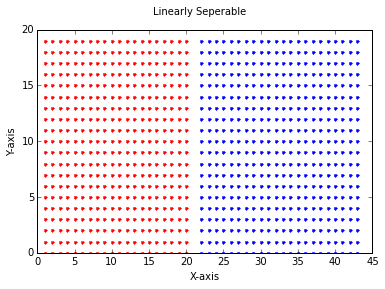

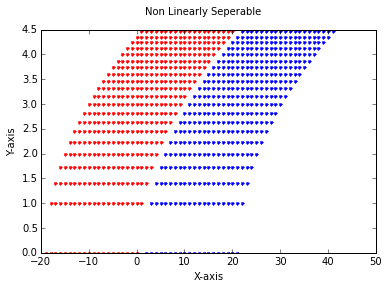

In [13]:
plot_SVM_data(20,2,20)

In [14]:
def compute_lagrange_multipliers(file_name,c=1,kernel=None,deg=2,gam=2):
    '''Compute the Lagrange Multipliers for all the examples and return them'''
    
    data = np.loadtxt(file_name,delimiter=',')

    
    m = data.shape[0]
    row_len = data.shape[1]

    Y = data[:,row_len-1:]
    YY_transpose = np.outer(Y,Y)

    X = data[:,0:row_len-1]
    
    
    XX_transpose  = np.zeros((m,m))

    for i in range(m):
        for j in range(m):
              XX_transpose[i,j] = np.dot(X[i], X[j])
    
    p = cvx.matrix(YY_transpose*XX_transpose)
    
    if kernel == 'poly':        
        XX_transpose = polynomial_kernel(X, X, degree=deg)
        polynomial_matrix = PolynomialFeatures(degree = deg)
        X = polynomial_matrix.fit_transform(X)
        p = cvx.matrix(Y.T * XX_transpose * Y)
    elif kernel == 'gaussian':
        XX_transpose = rbf_kernel(X, X, gamma=gam)
        p = cvx.matrix(Y.T * XX_transpose * Y)
    
    
    q = cvx.matrix(np.ones((m))*-1)

    g_top    = np.diag((np.ones(m)*-1))
    g_bottom = np.diag((np.ones(m)))
    g = cvx.matrix(np.concatenate((g_top, g_bottom), axis=0))

    h_top = np.zeros(m)
    h_bottom = (np.ones(m)*c)

    h = cvx.matrix(np.concatenate((h_top,h_bottom),axis=0))

    a = cvx.matrix(np.transpose(Y))
    b= cvx.matrix(0.0)


    sol = solvers.qp(p,q,g,h,a,b)
    alpha = (sol['x'])
    alpha = np.ravel(alpha)
    
    return alpha

In [15]:
def plot_support_vectors(sup_vecs,data,description):
    '''Plot the identified support vectors in green color'''
    
    X1_data = []
    y1_data = []
    X2_data = []
    y2_data = []
    X3_data = []
    y3_data = []

    for id,row in enumerate(data):
        if sup_vecs[id] == True:
            X3_data.append(row[0])
            y3_data.append(row[1])
        elif row[2] == 1:
            X1_data.append(row[0])
            y1_data.append(row[1])
        else:
            X2_data.append(row[0])
            y2_data.append(row[1])
        
    plot_data(X1_data,y1_data,'r.','X-axis','Y-axis','Y',X2_data,y2_data,'b.',description,'Y',X3_data,y3_data,'g.')

In [16]:
def train_SVM(file_name,c,alpha_threshold=0.01,plot_sup_vecs='N',kernel=None,deg=2,gam=2):
    '''Perform Training using below 3 steps:
       1. Solve the Dual Problem for Lagrange Multipliers
       2. Identify the Support Vector set (Non Zero Lagrange Multipliers)
       3. Compute W and W0
    '''
    
    #Step 1
    
    alphas = compute_lagrange_multipliers(file_name,c,kernel,deg,gam)
        
    #Step2
    sup_vecs = alphas > alpha_threshold
    
    data = np.loadtxt(file_name,delimiter=',')
    
    if plot_sup_vecs == 'Y':
        plot_support_vectors(sup_vecs,data,file_name)
    
    m = data.shape[0]
    row_len = data.shape[1]
    Y = data[:,row_len-1:]    
    X = data[:,0:row_len-1]
    
    #Step3
    W = np.zeros(row_len-1)
    
    for i in range(m):
        W += alphas[i]*Y[i][0]*X[i]
    
    W0 = np.zeros(row_len-1)
        
    no_of_sup_vecs = len([y for y in sup_vecs if y==True ])
    
    for i in range(m):
        if sup_vecs[i] == True:
            W0 += (Y[i][0] - np.dot(np.transpose(W),X[i]))
    
    W0 /= no_of_sup_vecs
    
    return W,W0

In [17]:
def predict(file_name,c,alpha_threshold,plot_sup_vecs='Y',kernel=None,deg=2,gam=2):
    '''Predict and return the confusion matrix'''
    #Train
    W,W0 = train_SVM(file_name,c,alpha_threshold,plot_sup_vecs,kernel,deg,gam)
    
    #Test    
    data = np.loadtxt(file_name,delimiter=',')
    m = data.shape[0]
    row_len = data.shape[1]

    Y = data[:,row_len-1:]    

    X = data[:,0:row_len-1]
    
    no_of_classes = len(set(data[:,row_len-1]))

    conf_matrix = np.zeros((no_of_classes,no_of_classes))

    for id,row in enumerate(X):    
        actual_class = Y[id][0]
        
        if (np.dot(np.transpose(W),row) + W0)[0] > 0:
            pred_class = 1
        else:
            pred_class = -1
        
        if pred_class == -1:
            pred_class = 0
        if actual_class == -1:
            actual_class = 0
        
        conf_matrix[pred_class,actual_class] += 1
        
    return conf_matrix        

In [18]:
def train_test_evaluate(file_name,c,alpha_threshold,plot_sup_vecs='Y',kernel=None,deg=2,gam=2):
    '''Evalute the performance of the SVM'''
    
    conf_matrix = predict(file_name,c,alpha_threshold,plot_sup_vecs,kernel,deg,gam)
    perf_measures = evaluate_performance(conf_matrix)
    print_perf_measures(conf_matrix,perf_measures)

#Linear Kernel

###Hard Margin - Linear Kernel

     pcost       dcost       gap    pres   dres
 0: -1.9627e+02 -1.4630e+03  6e+03  2e+00  6e-11
 1: -1.3226e+02 -7.5717e+02  1e+03  3e-01  6e-11
 2: -8.4110e+01 -2.1745e+02  3e+02  7e-02  4e-11
 3: -5.6787e+01 -9.2935e+01  1e+02  3e-02  2e-11
 4: -3.6507e+01 -5.5599e+01  7e+01  1e-02  2e-11
 5: -3.1688e+01 -2.5323e+01  4e+01  7e-03  1e-11
 6: -2.2238e+00 -3.3236e+01  4e+01  4e-03  6e-12
 7: -3.1572e+00 -3.2302e+01  4e+01  3e-03  5e-12
 8: -3.4054e+00 -1.9246e+01  3e+01  2e-03  3e-12
 9: -4.9200e-01 -1.3437e+00  1e+00  8e-05  1e-12
10: -4.9136e-01 -5.2772e-01  5e-02  3e-06  4e-13
11: -4.9991e-01 -5.0028e-01  5e-04  3e-08  5e-13
12: -5.0000e-01 -5.0000e-01  5e-06  3e-10  5e-13
13: -5.0000e-01 -5.0000e-01  5e-08  3e-12  5e-13
Optimal solution found.


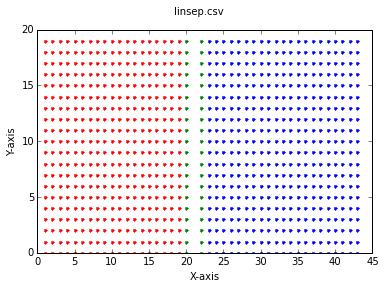


Confusion Matrix : 
[[ 440.    0.]
 [   0.  400.]]

Accuracy : 
1.0
Precision of class 1 is : 
1.0
Recall of class 1 is : 
1.0
F-Measure of class 1 is : 
1.0

Precision of class 2 is : 
1.0
Recall of class 2 is : 
1.0
F-Measure of class 2 is : 
1.0

     pcost       dcost       gap    pres   dres
 0: -2.0550e+02 -1.6926e+03  8e+03  3e+00  2e-11
 1: -1.3687e+02 -9.5232e+02  1e+03  3e-01  2e-11
 2: -9.0324e+01 -2.5060e+02  3e+02  6e-02  1e-11
 3: -6.7563e+01 -1.1645e+02  1e+02  2e-02  9e-12
 4: -5.7562e+01 -8.2504e+01  6e+01  1e-02  7e-12
 5: -5.2049e+01 -6.8582e+01  4e+01  6e-03  5e-12
 6: -4.9008e+01 -5.7958e+01  2e+01  3e-03  6e-12
 7: -4.7783e+01 -5.2138e+01  8e+00  1e-03  6e-12
 8: -4.7341e+01 -4.9040e+01  3e+00  4e-04  6e-12
 9: -4.7202e+01 -4.8096e+01  2e+00  2e-04  5e-12
10: -4.7151e+01 -4.7212e+01  8e-02  5e-06  6e-12
11: -4.7171e+01 -4.7171e+01  8e-04  5e-08  6e-12
12: -4.7171e+01 -4.7171e+01  8e-06  5e-10  6e-12
Optimal solution found.


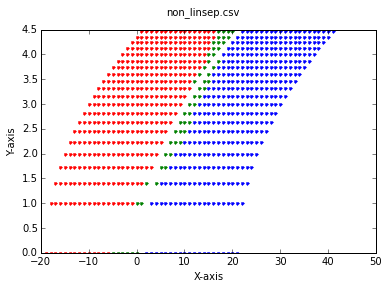


Confusion Matrix : 
[[ 411.    8.]
 [   9.  412.]]

Accuracy : 
0.979761904762
Precision of class 1 is : 
0.980906921241
Recall of class 1 is : 
0.978571428571
F-Measure of class 1 is : 
0.979737783075

Precision of class 2 is : 
0.978622327791
Recall of class 2 is : 
0.980952380952
F-Measure of class 2 is : 
0.979785969084



In [19]:
for file_name in ['linsep.csv','non_linsep.csv']:
    train_test_evaluate(file_name,1,0.01,plot_sup_vecs='Y',kernel='linear')

### Soft Margin - Linear Kernel

     pcost       dcost       gap    pres   dres
 0: -1.0304e+02 -6.6091e+01  4e+03  4e+01  3e-11
 1: -1.0514e+01 -6.2698e+01  1e+02  1e+00  3e-11
 2: -7.0427e+00 -2.6403e+01  3e+01  2e-01  6e-12
 3: -4.8522e+00 -1.0702e+01  1e+01  8e-02  3e-12
 4: -3.6598e+00 -6.3247e+00  7e+00  4e-02  2e-12
 5: -2.8779e+00 -4.0093e+00  4e+00  2e-02  1e-12
 6: -1.7652e+00 -3.1595e+00  3e+00  1e-02  8e-13
 7: -1.5289e+00 -1.6937e+00  1e+00  5e-03  6e-13
 8: -1.2072e+00 -1.2371e+00  1e+00  4e-03  6e-13
 9: -2.4437e-01 -8.0395e-01  6e-01  3e-16  6e-13
10: -4.8535e-01 -5.3506e-01  5e-02  3e-16  4e-13
11: -4.9985e-01 -5.0038e-01  5e-04  4e-16  4e-13
12: -5.0000e-01 -5.0000e-01  5e-06  8e-16  4e-13
13: -5.0000e-01 -5.0000e-01  5e-08  9e-16  4e-13
Optimal solution found.


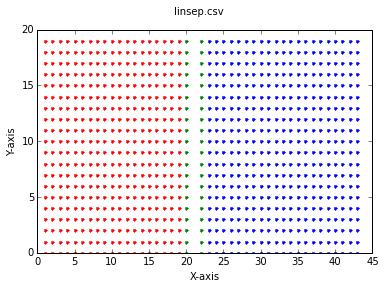


Confusion Matrix : 
[[ 440.    0.]
 [   0.  400.]]

Accuracy : 
1.0
Precision of class 1 is : 
1.0
Recall of class 1 is : 
1.0
F-Measure of class 1 is : 
1.0

Precision of class 2 is : 
1.0
Recall of class 2 is : 
1.0
F-Measure of class 2 is : 
1.0

     pcost       dcost       gap    pres   dres
 0: -1.0795e+02 -7.3149e+01  4e+03  5e+01  9e-12
 1: -1.1103e+01 -6.9791e+01  2e+02  1e+00  8e-12
 2: -7.3841e+00 -3.2301e+01  4e+01  2e-01  2e-12
 3: -5.2686e+00 -1.2686e+01  1e+01  6e-02  9e-13
 4: -4.3813e+00 -6.1521e+00  3e+00  1e-02  7e-13
 5: -4.2735e+00 -4.6799e+00  6e-01  2e-03  6e-13
 6: -4.2924e+00 -4.3971e+00  1e-01  5e-04  5e-13
 7: -4.2951e+00 -4.3346e+00  5e-02  1e-04  6e-13
 8: -4.3028e+00 -4.3128e+00  1e-02  2e-05  6e-13
 9: -4.3061e+00 -4.3064e+00  3e-04  4e-15  7e-13
10: -4.3062e+00 -4.3062e+00  3e-06  5e-15  6e-13
Optimal solution found.


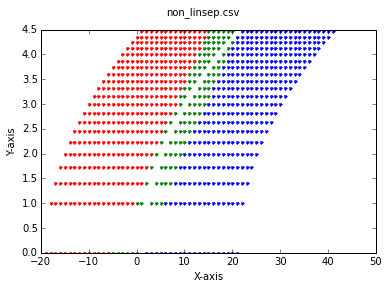


Confusion Matrix : 
[[ 411.   12.]
 [   9.  408.]]

Accuracy : 
0.975
Precision of class 1 is : 
0.971631205674
Recall of class 1 is : 
0.978571428571
F-Measure of class 1 is : 
0.975088967972

Precision of class 2 is : 
0.978417266187
Recall of class 2 is : 
0.971428571429
F-Measure of class 2 is : 
0.974910394265



In [20]:
for file_name in ['linsep.csv','non_linsep.csv']:
    train_test_evaluate(file_name,0.05,0.01,plot_sup_vecs='Y',kernel='linear')

# Polynomial Kernel

     pcost       dcost       gap    pres   dres
 0: -1.0220e+02 -6.5487e+01  3e+03  4e+01  1e-09
 1: -1.0448e+01 -6.2096e+01  1e+02  1e+00  1e-09
 2: -7.0215e+00 -2.6601e+01  3e+01  2e-01  3e-10
 3: -4.9660e+00 -1.1989e+01  1e+01  9e-02  1e-10
 4: -3.7593e+00 -6.9163e+00  8e+00  4e-02  7e-11
 5: -2.9765e+00 -4.7770e+00  5e+00  3e-02  5e-11
 6: -2.5007e+00 -4.1821e+00  5e+00  2e-02  4e-11
 7: -2.0562e+00 -3.3224e+00  3e+00  1e-02  3e-11
 8: -1.8410e+00 -2.8233e+00  3e+00  1e-02  2e-11
 9: -1.6090e+00 -2.6410e+00  3e+00  9e-03  2e-11
10: -1.4748e+00 -2.4067e+00  2e+00  7e-03  2e-11
11: -1.2779e+00 -2.0754e+00  2e+00  5e-03  2e-11
12: -1.1079e+00 -1.8117e+00  1e+00  3e-03  2e-11
13: -1.0483e+00 -1.6272e+00  1e+00  2e-03  2e-11
14: -1.0195e+00 -1.2288e+00  3e-01  4e-04  2e-11
15: -1.0510e+00 -1.0886e+00  4e-02  2e-05  2e-11
16: -1.0641e+00 -1.0692e+00  5e-03  2e-06  2e-11
17: -1.0663e+00 -1.0664e+00  7e-05  2e-08  2e-11
18: -1.0663e+00 -1.0663e+00  7e-07  2e-10  2e-11
Optimal solution foun

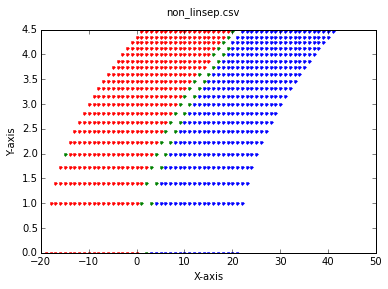


Confusion Matrix : 
[[ 385.   64.]
 [  35.  356.]]

Accuracy : 
0.882142857143
Precision of class 1 is : 
0.857461024499
Recall of class 1 is : 
0.916666666667
F-Measure of class 1 is : 
0.886075949367

Precision of class 2 is : 
0.910485933504
Recall of class 2 is : 
0.847619047619
F-Measure of class 2 is : 
0.877928483354



In [21]:
for file_name in ['non_linsep.csv']:
    train_test_evaluate(file_name,0.05,0.01,plot_sup_vecs='Y',kernel='poly',deg=2)

#Gaussian Kernel

     pcost       dcost       gap    pres   dres
 0: -7.2588e+01 -1.4194e+03  6e+03  2e+00  7e-15
 1: -4.0356e+01 -6.9272e+02  8e+02  9e-02  9e-15
 2: -5.2347e+01 -1.8553e+02  1e+02  2e-02  7e-15
 3: -6.8696e+01 -1.1018e+02  4e+01  3e-03  8e-15
 4: -7.4272e+01 -9.0879e+01  2e+01  1e-03  8e-15
 5: -7.6737e+01 -8.2507e+01  6e+00  3e-04  8e-15
 6: -7.7701e+01 -7.9658e+01  2e+00  7e-05  1e-14
 7: -7.7850e+01 -7.9322e+01  1e+00  4e-05  8e-15
 8: -7.8208e+01 -7.8583e+01  4e-01  7e-06  8e-15
 9: -7.8282e+01 -7.8461e+01  2e-01  2e-06  8e-15
10: -7.8346e+01 -7.8368e+01  2e-02  2e-07  9e-15
11: -7.8354e+01 -7.8357e+01  3e-03  1e-08  9e-15
12: -7.8356e+01 -7.8356e+01  1e-04  7e-10  1e-14
13: -7.8356e+01 -7.8356e+01  2e-05  4e-11  9e-15
Optimal solution found.


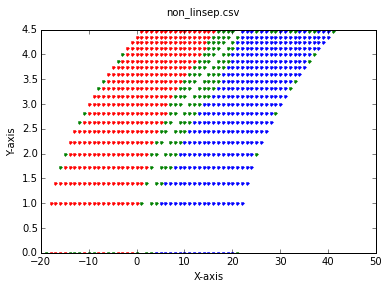


Confusion Matrix : 
[[ 366.   45.]
 [  54.  375.]]

Accuracy : 
0.882142857143
Precision of class 1 is : 
0.890510948905
Recall of class 1 is : 
0.871428571429
F-Measure of class 1 is : 
0.880866425993

Precision of class 2 is : 
0.874125874126
Recall of class 2 is : 
0.892857142857
F-Measure of class 2 is : 
0.883392226148



In [22]:
for file_name in ['non_linsep.csv']:
    train_test_evaluate(file_name,1,0.01,plot_sup_vecs='Y',kernel='gaussian',gam=0.08)

### SVM on Dataset with more examples of a particular class

     pcost       dcost       gap    pres   dres
 0: -3.7933e+01 -4.0210e+01  2e+03  5e+01  7e-11
 1: -4.1707e+00 -3.8219e+01  1e+02  1e+00  7e-11
 2: -2.8268e+00 -1.8351e+01  3e+01  3e-01  2e-11
 3: -1.7813e+00 -6.3845e+00  8e+00  8e-02  8e-12
 4: -1.2493e+00 -2.6266e+00  2e+00  2e-02  5e-12
 5: -1.1165e+00 -1.4543e+00  6e-01  5e-03  4e-12
 6: -1.0606e+00 -1.2851e+00  3e-01  2e-03  3e-12
 7: -1.0591e+00 -1.1105e+00  7e-02  4e-04  3e-12
 8: -1.0656e+00 -1.0692e+00  5e-03  2e-05  4e-12
 9: -1.0663e+00 -1.0665e+00  2e-04  7e-07  5e-12
10: -1.0663e+00 -1.0663e+00  2e-06  7e-09  6e-12
11: -1.0663e+00 -1.0663e+00  2e-08  7e-11  4e-12
Optimal solution found.


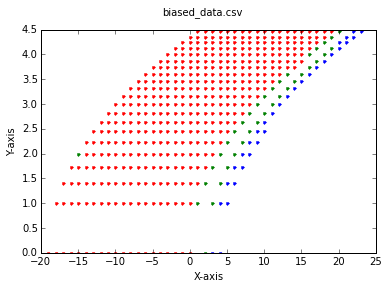


Confusion Matrix : 
[[  28.   64.]
 [  21.  356.]]

Accuracy : 
0.818763326226
Precision of class 1 is : 
0.304347826087
Recall of class 1 is : 
0.571428571429
F-Measure of class 1 is : 
0.397163120567

Precision of class 2 is : 
0.944297082228
Recall of class 2 is : 
0.847619047619
F-Measure of class 2 is : 
0.893350062735



In [23]:
for file_name in ['biased_data.csv']:
    train_test_evaluate(file_name,0.05,0.01,plot_sup_vecs='Y',kernel='poly',deg=2)